# Cross-species annotation
### PreProcessing (see on merge_data.ipynb)
0) Select and download relevant datasets
1) Condense similar annotation info into same obs columns
2) Map gene variables to homologus gene variables
3) QC + Basic Filtering
6) Subset each dataset.var by only shared genes by at least 2 species
7) Merge datasets (outer merge to conserve obs-metadata, fill_value=0)

### Processing (this notebook)

8) Scale & PCA
9) Spearman correlation of PC to QC metrics & drop technical PC
9) Harmony integration
10) Neighbors / clustering on integrated representation
11) Compute overlap metrics (per-cluster entropy & species fractions)
12) Cross-validation evaluation (hide 20% human+mouse, majority-vote, cofusion matrix)

In [1]:
import os
import glob
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import harmonypy as hm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
rev_n = 9

## Pre-processing
- Start with raw_merged data
- Filter
- Normalize
- Log transform
- Find HVG
- Combat (batch correction)

In [ ]:
filename = f'/home/raquelcr/scanpy/out_datasets/all_adata_outer{rev_n}.h5ad'
adata = sc.read(filename)
print(f"Succesfully loaded {filename}. Shape: {adata.shape}")

Succesfully loaded /home/raquelcr/scanpy/out_datasets/all_adata_outer9.h5ad. Shape: (62357, 13337)


In [4]:
adata

AnnData object with n_obs × n_vars = 62357 × 13337
    obs: 'species', 'tissue', 'sample_id', 'replicate', 'sample', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'Tissue', 'TotalUMIs', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'cluster_id', 'roi', 'cell_type', 'cell_supertype', 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'tissue_type', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'd

In [5]:
# Densidad de la matriz .X
55630240/(62357*13337)

0.06689098163383456

In [6]:
print(adata.shape)
print(adata.obs.columns)
print(adata.obs['dataset_name'].value_counts())

(62357, 13337)
Index(['species', 'tissue', 'sample_id', 'replicate', 'sample', 'region',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'Tissue', 'TotalUMIs',
       'organism_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id',
       'sex_ontology_term_id', 'development_stage_ontology_term_id',
       'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'cluster_id',
       'roi', 'cell_type', 'cell_supertype', 'Age', 'CellClass', 'Chemistry',
       'Region', 'Subregion', 'tissue_type', 'tissue_ontology_term_id',
       'cell_type_ontology_term_id', 'fraction_mitochondrial',
      

### QC metrics

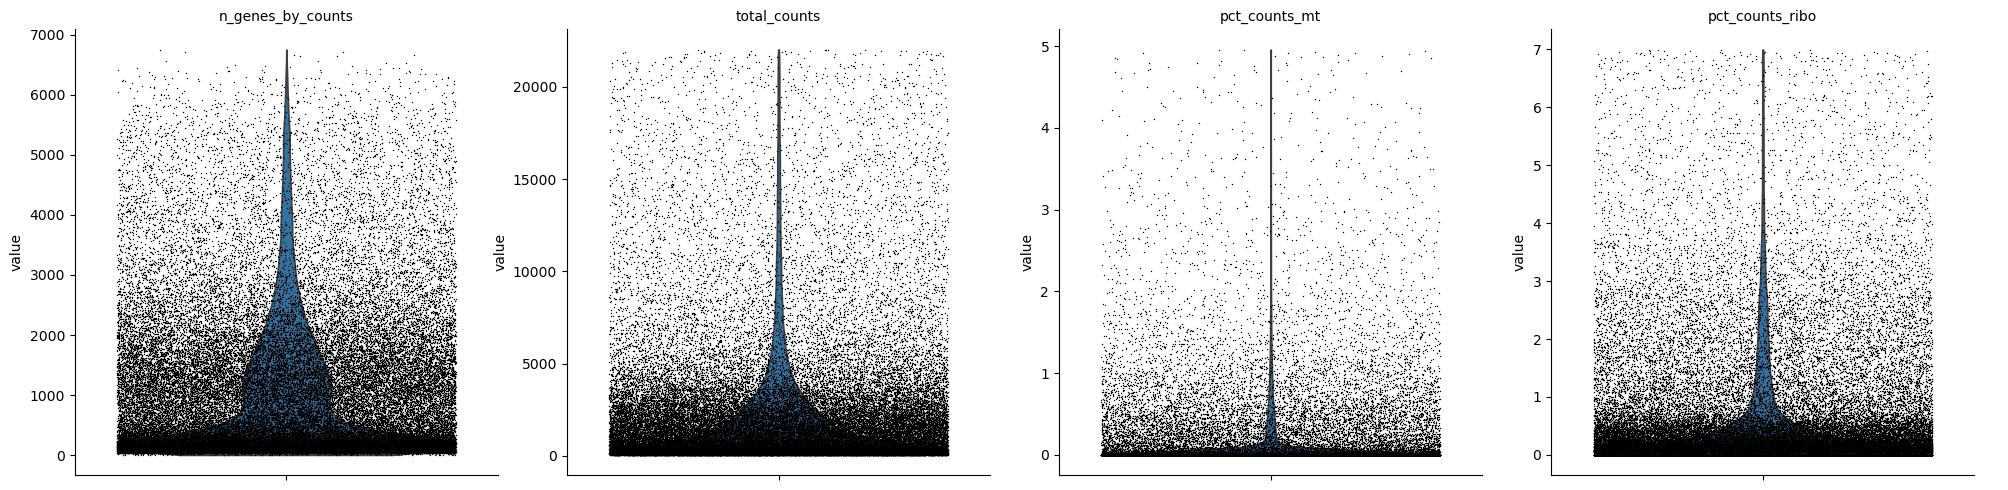

In [7]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", 'pct_counts_ribo'],
    jitter=0.4,
    multi_panel=True
)

### HVG

In [8]:
sc.pp.normalize_total(adata, exclude_highly_expressed=True, max_fraction=0.05)

In [9]:
sc.pp.log1p(adata)

In [10]:
sc.pp.highly_variable_genes(adata, n_top_genes = 5000, subset=False)

In [11]:
adata.var

highly_variable     means  dispersions  dispersions_norm
A1CF               False  0.006053     0.532436         -0.551278
A2M                False  0.004130     0.283270         -0.779767
A3GALT2            False  0.002085     0.797201         -0.308484
A4GALT             False  0.000221     0.494129         -0.586406
A4GNT              False  0.000005    -1.855500         -2.741056
...                  ...       ...          ...               ...
ZWINT              False  0.001206     0.991425         -0.130377
ZXDC                True  0.050879     1.796540          0.607927
ZYX                 True  0.004858     2.068439          0.857263
ZZEF1              False  0.166941     1.302567         -0.970543
ZZZ3                True  0.096716     1.306381          0.158443

[13337 rows x 4 columns]

I have seen that normalization prior to harmony affects overlap, therefore we will subset the genes by the top highly variable, but avoiding to modify the adata.X

### Scale and PCA

In [12]:
sc.pp.scale(adata)
sc.pp.pca(adata, svd_solver='arpack', use_highly_variable=True)

KeyboardInterrupt: 

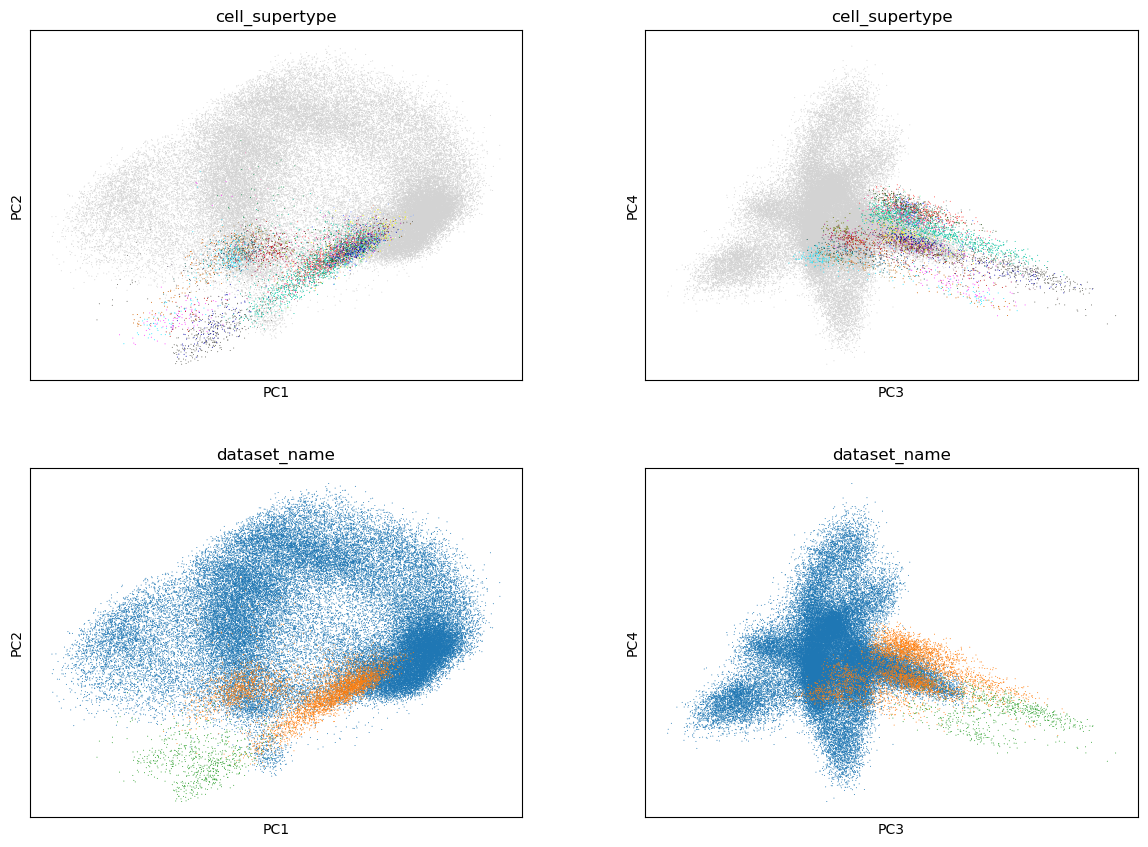

In [ ]:
sc.pl.pca(
    adata,
    color=["cell_supertype","cell_supertype", "dataset_name", "dataset_name"],
    dimensions=[(0,1),(2,3), (0,1),(2,3)],
    ncols=2,
    size=2,
    save=f'_by_supertype{rev_n}.png',
    legend_loc='none' 
)

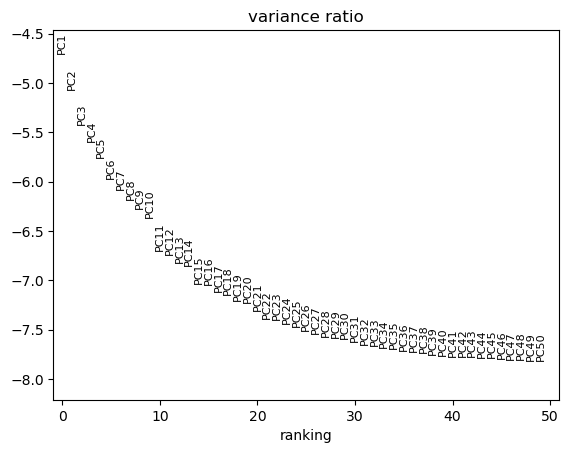

In [ ]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True, save=f'{rev_n}.png')

In [ ]:
from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import multipletests
def check_pc_correlation(adata, n_pcs=None, pc_col_name="X_pca"):
    """Check correlation between PCs and QC metrics to identify potential confounders."""
    if n_pcs is None:
        n_pcs_check = adata.obsm[pc_col_name].shape[1]
    else: n_pcs_check = min(n_pcs, adata.obsm[pc_col_name].shape[1])
    pcs = pd.DataFrame(
        adata.obsm[pc_col_name][:, :n_pcs_check],
        index=adata.obs_names,
        columns=["PC"+str(i+1).zfill(2) for i in range(n_pcs_check)]
    )

    qc_cols = ["total_counts", "n_genes_by_counts", "pct_counts_mt", 'pct_counts_ribo']
    qc = adata.obs[qc_cols].astype(float)
    qc['species'] = adata.obs['species'].astype('category').cat.codes
    qc_cols.append('species')

    rows = []
    for pc in pcs.columns:
        for cov in qc_cols:
            # Spearman es más robusto; cambia a pearsonr si prefieres lineal
            r, p = spearmanr(pcs[pc].values, qc[cov].values, nan_policy="omit")
            rows.append({"PC": pc, "covariate": cov, "r": r, "p": p})

    corr = pd.DataFrame(rows)
    corr["q"] = multipletests(corr["p"], method="fdr_bh")[1]


    return corr

In [ ]:
def plot_pc_qc_correlation(corr, save_path=None):
    """Plot heatmap of PC vs QC metric correlations."""
    mat = corr.pivot(index="covariate", columns="PC", values="r")
    plt.figure(figsize=(10,3))
    im = plt.imshow(mat.values, aspect="auto", interpolation="nearest")
    plt.yticks(range(mat.shape[0]), mat.index)
    plt.xticks(range(mat.shape[1]), mat.columns, rotation=90)
    plt.colorbar(im, label="Spearman r")
    plt.title("Correlation PC vs QC")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    

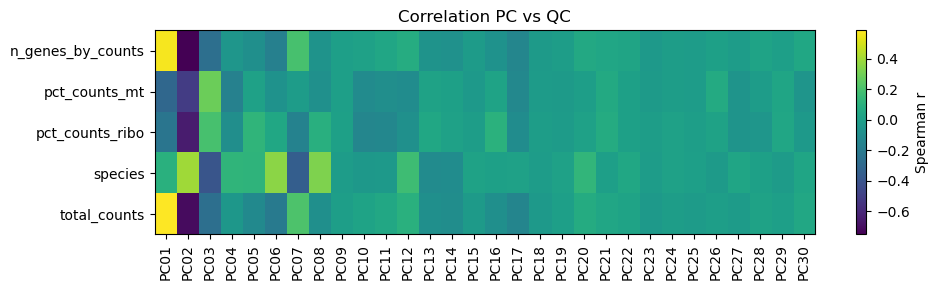

In [ ]:
origPCcorr = check_pc_correlation(adata, n_pcs=30, pc_col_name="X_pca")
plot_pc_qc_correlation(origPCcorr, save_path=f'pc_qc_correlation_before_harmony{rev_n}.png')

In [ ]:
# PC2 and PC4 looks problematic so I rather delete it
adata_copy = adata.copy() # save backup
#adata.obsm["X_pca"] = np.delete(adata.obsm["X_pca"], [1,3], axis=1) 

In [ ]:
#return to this checkpoint
adata = adata_copy.copy()

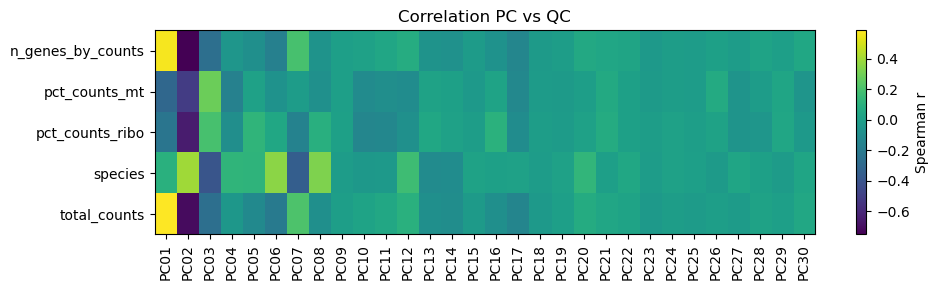

In [ ]:
secondPCcorr = check_pc_correlation(adata, n_pcs=30, pc_col_name="X_pca")
plot_pc_qc_correlation(secondPCcorr, save_path=f'pc_qc_correlation_pc2_dropped{rev_n}.png')
# just a little improvement

## scANVI Integration

In [24]:
adata

AnnData object with n_obs × n_vars = 62357 × 13337
    obs: 'species', 'tissue', 'sample_id', 'replicate', 'sample', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'Tissue', 'TotalUMIs', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'cluster_id', 'roi', 'cell_type', 'cell_supertype', 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'tissue_type', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'd

In [ ]:
import numpy as np
import scvi
import torch.nn
from scvi.data import AnnDataManager
from scvi.data.fields import CategoricalObsField, LayerField
from scvi.dataloaders import AnnDataLoader

In [ ]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

### Harmony Integration

In [ ]:
pca_mat = adata.obsm['X_pca']
harmony_out = hm.run_harmony(pca_mat, adata.obs, 'dataset_name', plot_convergence=True)
adata.obsm['X_pca_harmony'] = harmony_out.Z_corr.T  # check harmonypy return shape; adapt accordingly
# many wrappers exist; alternatively use sc.external.pp.harmony_integrate if available


2025-10-18 10:04:03,283 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2025-10-18 10:04:19,843 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-18 10:04:21,039 - harmonypy - INFO - Iteration 1 of 10
2025-10-18 10:04:50,179 - harmonypy - INFO - Iteration 2 of 10
2025-10-18 10:05:23,619 - harmonypy - INFO - Iteration 3 of 10
2025-10-18 10:05:57,732 - harmonypy - INFO - Iteration 4 of 10
2025-10-18 10:06:28,620 - harmonypy - INFO - Iteration 5 of 10
2025-10-18 10:06:59,103 - harmonypy - INFO - Iteration 6 of 10
2025-10-18 10:07:33,302 - harmonypy - INFO - Iteration 7 of 10
2025-10-18 10:08:07,015 - harmonypy - INFO - Iteration 8 of 10
2025-10-18 10:08:41,707 - harmonypy - INFO - Iteration 9 of 10
2025-10-18 10:09:09,463 - harmonypy - INFO - Iteration 10 of 10
2025-10-18 10:09:37,093 - harmonypy - INFO - Converged after 10 iterations


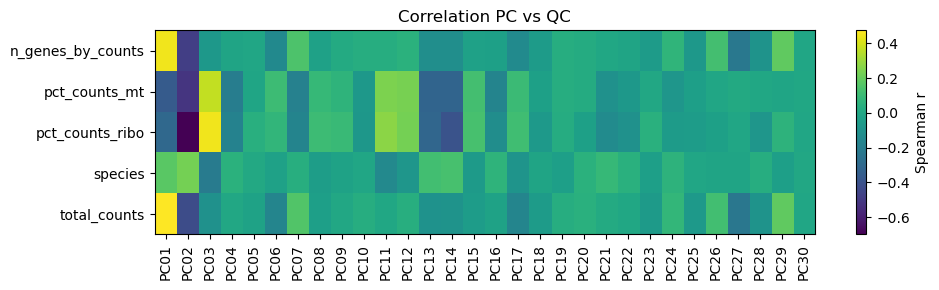

In [ ]:
harmonyPCcorr = check_pc_correlation(adata, n_pcs=30, pc_col_name="X_pca_harmony")
plot_pc_qc_correlation(harmonyPCcorr, save_path=f'pc_qc_correlation_after_harmony{rev_n}.png')

In [ ]:
# sc.pp.combat(adata_hvg, key='dataset_name', inplace=True)
# combat is another type of batch correction, but harmonypy is generally better

### Normalize

In [ ]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)

### Neighbors
**Small n_neighbors** (e.g. 5–10): 

- Highlights fine-grained local relationships.

- Good for detecting rare cell populations. But can fragment larger, continuous populations into many tiny clusters.

**Large n_neighbors** (e.g. 30–50):

- Incorporates more global structure.

- Produces more coarse and global clusters.

- Good for datasets with strong batch effects (less sensitive to noise). But can miss rare cell types because they get merged into neighbors’ majority.


In [ ]:
#Using rule of thumb  for n_neigbors used on neighors
import math
n_cells = adata.shape[0]
n_neighb = int(math.log10(n_cells) * 10)
print(f"Recommended n_neighbors ~ {n_neighb}")

Recommended n_neighbors ~ 47


In [23]:
len(adata.obsm['X_pca_harmony'][0])

KeyError: 'X_pca_harmony'

In [ ]:
rep = 'X_pca_harmony'  # use this integrated representation for clustering
sc.pp.neighbors(adata, use_rep=rep, n_neighbors=n_neighb,n_pcs=50)


/home/raquelcr/.conda/envs/scanpy-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Clustering

In [22]:
sc.tl.leiden(adata, resolution=2.5, key_added='leiden_2.5')


KeyError: 'No "neighbors" in .uns'

### UMAP

In [21]:
sc.tl.umap(adata, min_dist=0.2) 

ValueError: Did not find .uns['neighbors']. Run `sc.pp.neighbors` first.

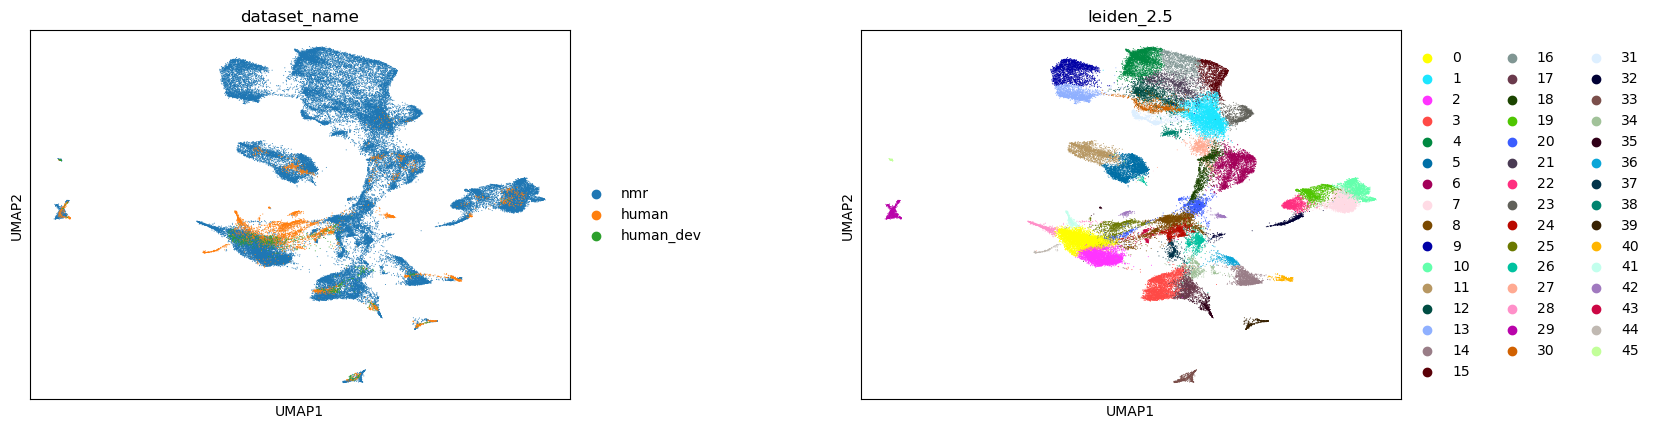

In [ ]:
sc.pl.umap(adata, color=['dataset_name', 'leiden_2.5'], wspace=0.4, save=f"_clusters_harmony{rev_n}.png")

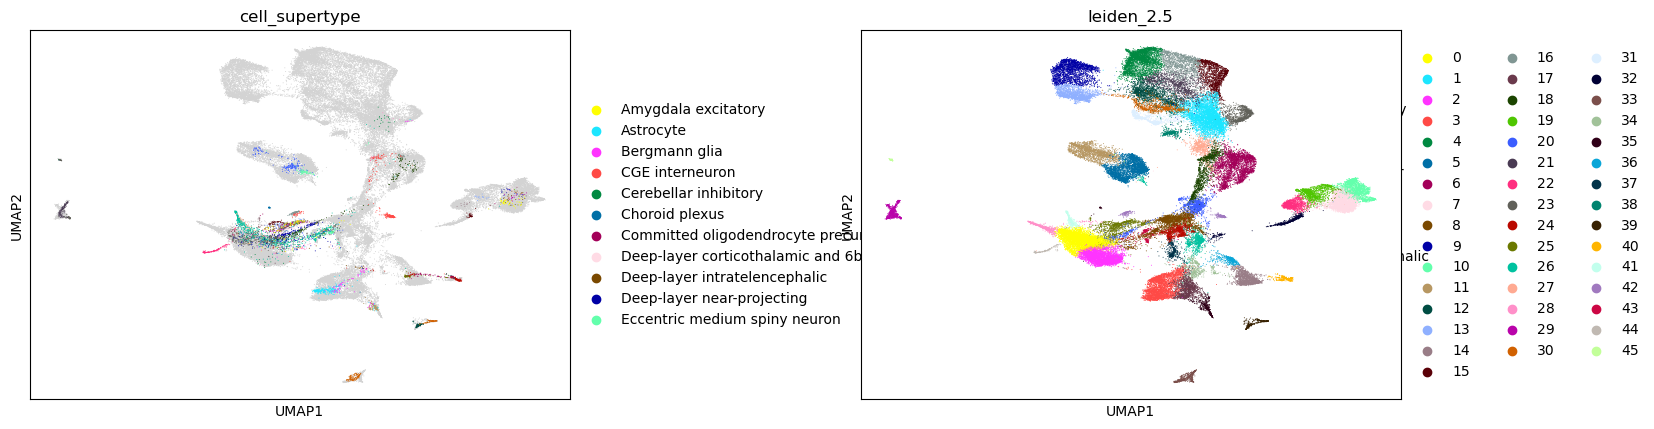

In [ ]:
sc.pl.umap(adata, color=['cell_supertype', 'leiden_2.5'], wspace=0.4, save=f"_clusters_harmony_types{rev_n}.png")

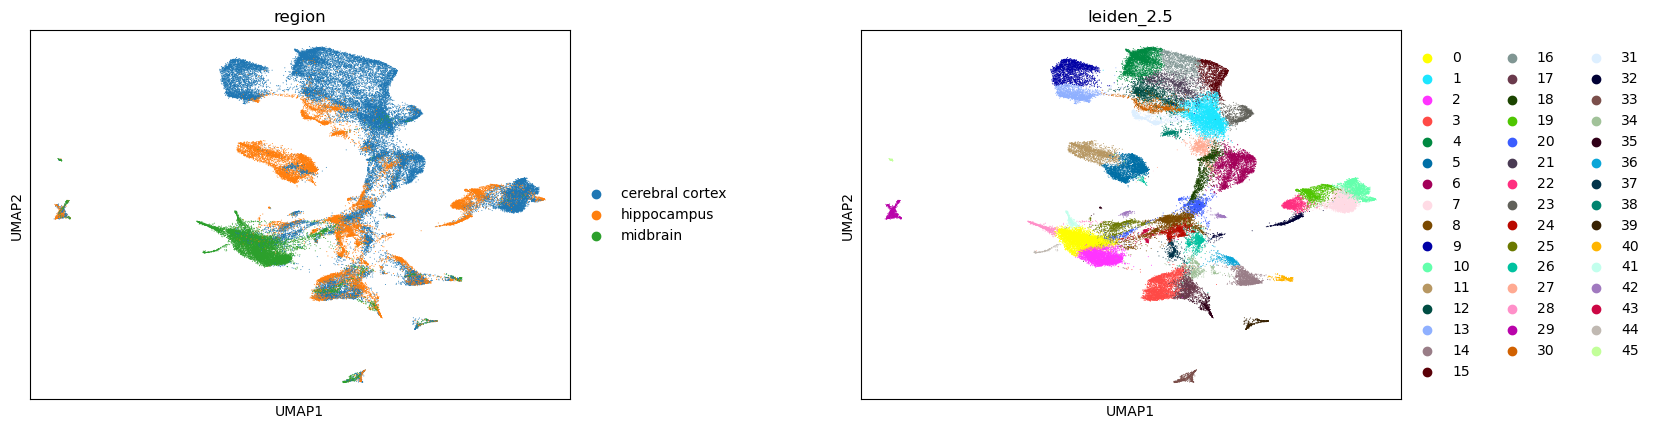

In [ ]:
sc.pl.umap(adata, color=['region', 'leiden_2.5'], wspace=0.4, save=f"_clusters_harmony_region{rev_n}.png")

In [ ]:
## CHECKPOINT
filename = f'/home/raquelcr/scanpy/integrated_adata_clusters{rev_n}.h5ad'
adata.write_h5ad(filename)
print(f"AnnData object successfully saved to {filename}")

AnnData object successfully saved to /home/raquelcr/scanpy/integrated_adata_clusters9.h5ad


In [1]:
!cd /home/raquelcr/scanpy/

#### Don't re-run previous code ;)
(too slow)

In [4]:
try: adata = adata.copy()
except: adata = sc.read(f'/home/raquelcr/scanpy/integrated_adata_clusters{rev_n}.h5ad')

## Metrics calculation

In [5]:
def shannon_entropy_from_counts(counts, base=2):
    """Shannon entropy from a list/array of counts."""
    counts = np.array(counts, dtype=float)
    if counts.sum() == 0:
        return 0.0
    p = counts / counts.sum()
    p = p[p > 0]
    return entropy(p, base=base)


In [6]:
def icc_1way_single_measure(groups, values):
    """
    One-way random effects ICC(1,1).
    groups: array of group labels
    values: array of numeric values
    """
    groups = np.array(groups)
    values = np.array(values, dtype=float)
    unique_g = np.unique(groups)

    N = len(values)
    k = len(unique_g)
    n_i = np.array([np.sum(groups == g) for g in unique_g])

    mean_all = np.mean(values)
    mean_i = np.array([np.mean(values[groups == g]) for g in unique_g])

    ss_between = np.sum(n_i * (mean_i - mean_all) ** 2)
    ms_between = ss_between / (k - 1)

    ss_within = sum(
        np.sum((values[groups == g] - values[groups == g].mean()) ** 2)
        for g in unique_g
    )
    ms_within = ss_within / (N - k) if N > k else 0.0

    denom = ms_between + (n_i.mean() - 1) * ms_within
    icc = (ms_between - ms_within) / denom if denom > 0 else 0.0
    return icc


In [7]:
def compute_cluster_metrics(adata,
                            species_col='species',
                            cluster_col='cluster',
                            ann_col='annotation',
                            species_list=('human', 'mouse', 'nmr')):
    """
    Returns a pandas DataFrame with metrics per cluster.
    """
    obs = adata.obs.copy()
    # ensure cluster col is string-like
    obs['_cluster_str'] = obs[cluster_col].astype(str)
    clusters = obs['_cluster_str'].unique()
    rows = []
    for cl in sorted(clusters, key=lambda x: (float(x) if x.replace('.','',1).isdigit() else x)):
        sub = obs[obs['_cluster_str'] == cl]
        n_cells = len(sub)
        # pct not annotated (cells where ann_col is NA / empty)
        not_ann = sub[ann_col].isna() | (sub[ann_col].astype(str).str.strip() == '')
        pct_not_annotated = not_ann.sum() / max(1, n_cells)
        # species mix entropy
        species_counts = sub[species_col].value_counts()
        # make sure we compute entropy over species_list order if provided
        species_counts_list = [species_counts.get(s, 0) for s in species_list]
        ent_species = shannon_entropy_from_counts(species_counts_list, base=2)
        # ICC: here we compute ICC of "species label as numeric group" on a dummy numeric vector (1s),
        # but that's meaningless. A better practical ICC for per-cluster species homogeneity:
        # compute ICC of a binary indicator per species across annotated identities:
        # instead compute ICC of species fraction across per-cell one-hot for species groups.
        # Implementation: for this cluster, create groups = species, values = 1 for each cell,
        # then ICC is computed across species groups — this effectively measures between-group variance.
        # (This is a proxy; you can replace with another continuous metric if preferred.)
        groups = sub[species_col].values
        values = np.ones(len(sub))
        icc_sp = icc_1way_single_measure(groups, values)
        # For human and mouse majority annotation within cluster:
        info = {'cluster': cl, 'n_cells': n_cells,
                'pct_not_annotated': pct_not_annotated,
                'shannon_entropy_species': ent_species,
                'icc_species_fraction': icc_sp}
        for sp in ['human', 'mouse']:
            sub_sp = sub[sub[species_col] == sp]
            if len(sub_sp) == 0:
                info[f'{sp}_majority_annotation'] = np.nan
                info[f'{sp}_majority_frac'] = np.nan
            else:
                # among these, consider only annotated cells
                ann_counts = sub_sp[~(sub_sp[ann_col].isna() | (sub_sp[ann_col].astype(str).str.strip() == ''))][ann_col].value_counts()
                if ann_counts.sum() == 0:
                    info[f'{sp}_majority_annotation'] = np.nan
                    info[f'{sp}_majority_frac'] = 0.0
                else:
                    maj_ann = ann_counts.idxmax()
                    maj_frac = ann_counts.loc[maj_ann] / ann_counts.sum()
                    info[f'{sp}_majority_annotation'] = maj_ann
                    info[f'{sp}_majority_frac'] = float(maj_frac)
        # global majority among annotated cells in cluster
        ann_counts_global = sub[~(sub[ann_col].isna() | (sub[ann_col].astype(str).str.strip() == ''))][ann_col].value_counts()
        if ann_counts_global.sum() == 0:
            info['global_majority_annotation'] = np.nan
            info['global_majority_frac'] = 0.0
        else:
            gmaj = ann_counts_global.idxmax()
            info['global_majority_annotation'] = gmaj
            info['global_majority_frac'] = float(ann_counts_global.loc[gmaj] / ann_counts_global.sum())
        rows.append(info)
    cluster_metrics = pd.DataFrame(rows).set_index('cluster')
    return cluster_metrics


In [8]:
def assign_cluster_majority(adata, cluster_metrics, ann_col='annotation', cluster_col='cluster'):
    """Add predicted annotation to adata.obs as 'predicted_annotation' based on cluster global majority."""
    obs = adata.obs
    # map cluster -> global_majority_annotation
    mapping = cluster_metrics['global_majority_annotation'].to_dict()
    obs['predicted_annotation'] = obs[cluster_col].astype(str).map(mapping).astype(object)
    # leave as NaN where mapping missing
    return None  # adata modified in place

In [9]:
# Pipeline for cross-species cluster-based annotation + metrics

def cross_validate_cluster_majority(adata,
                                    ann_col='annotation',
                                    species_col='species',
                                    cluster_col='cluster',
                                    species_to_mask=('human', 'mouse'),
                                    test_fraction=0.2,
                                    random_state=0):
    """
    For each species in species_to_mask:
      - stratify by annotation (if enough cells) and select test_fraction to hide
    Then: compute cluster majority using remaining labels and predict on held-out labels.
    Returns accuracy, confusion matrix and the indices of test cells.
    """
    obs = adata.obs.copy()
    # get indices for candidates (human+mouse annotated)
    candidates = obs[obs[species_col].isin(species_to_mask)].copy()
    # ensure annotated
    candidates = candidates[~(candidates[ann_col].isna() | (candidates[ann_col].astype(str).str.strip() == ''))]
    if candidates.empty:
        raise ValueError("No annotated human/mouse cells found for cross-validation.")
    test_idx = []
    train_mask = pd.Series(True, index=obs.index)
    # stratify within each species separately
    for sp in species_to_mask:
        sp_idx = candidates[candidates[species_col] == sp].index
        if len(sp_idx) == 0:
            continue
        y = candidates.loc[sp_idx, ann_col].values
        # if number of unique classes small or counts small, train_test_split stratify might fail.
        try:
            train_i, test_i = train_test_split(sp_idx, test_size=test_fraction, stratify=y, random_state=random_state)
        except Exception:
            # fallback: random sample
            test_i = np.random.RandomState(random_state).choice(sp_idx, size=max(1, int(len(sp_idx)*test_fraction)), replace=False)
            train_i = [i for i in sp_idx if i not in test_i]
        test_idx.extend(list(test_i))
        # mark those as hidden for training
        train_mask.loc[test_i] = False
    # create a copy of annotations for training where we mask test_idx
    obs_train = obs.copy()
    obs_train.loc[test_idx, ann_col] = np.nan
    # compute cluster majority from obs_train
    # build cluster -> majority annotation across all annotated cells in cluster (human+mouse+other if present)
    cluster_majority = {}
    for cl, sub in obs_train.groupby(cluster_col):
        ann_counts = sub[~(sub[ann_col].isna() | (sub[ann_col].astype(str).str.strip() == ''))][ann_col].value_counts()
        if ann_counts.sum() == 0:
            cluster_majority[cl] = np.nan
        else:
            cluster_majority[cl] = ann_counts.idxmax()
    # predictions for test cells
    y_true = obs.loc[test_idx, ann_col].values
    y_pred = [cluster_majority.get(cl, np.nan) for cl in obs.loc[test_idx, cluster_col].astype(str).values]
    # compute accuracy (ignore nan predictions if they occur)
    mask_valid = pd.Series(y_pred).notna().values
    if mask_valid.sum() == 0:
        acc = np.nan
    else:
        acc = accuracy_score(np.array(y_true)[mask_valid], np.array(y_pred)[mask_valid])
    # confusion matrix across classes that appear in true set (will include only predicted ones for which mapping exists)
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, pd.Series(y_pred), labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    return {'accuracy': float(acc) if not np.isnan(acc) else np.nan,
            'confusion_matrix': cm_df,
            'n_test': len(test_idx),
            'test_idx': test_idx,
            'cluster_majority_from_train': cluster_majority}



In [10]:
leiden_res = 'leiden_2.5'
cluster_metrics = compute_cluster_metrics(adata, species_col='species', cluster_col=leiden_res, ann_col='cell_supertype')
print(cluster_metrics.head())
assign_cluster_majority(adata, cluster_metrics, ann_col='cell_supertype', cluster_col=leiden_res)
cv_results = cross_validate_cluster_majority(adata, ann_col='cell_supertype', cluster_col=leiden_res, species_col='species')
print("CV accuracy:", cv_results['accuracy'])
print("Confusion matrix:\n", cv_results['confusion_matrix'])
cluster_metrics.to_csv('/home/raquelcr/scanpy/harmony_cluster_metrics.csv')

         n_cells  pct_not_annotated  shannon_entropy_species  \
cluster                                                        
0           4700           0.831489                 0.654286   
1           4151           0.993014                 0.060074   
2           3743           0.978092                 0.152021   
3           2997           0.906907                 0.446711   
4           2942           1.000000                 0.000000   

         icc_species_fraction human_majority_annotation  human_majority_frac  \
cluster                                                                        
0                         0.0                  Splatter             0.410354   
1                         0.0     Cerebellar inhibitory             0.724138   
2                         0.0                  Splatter             0.280488   
3                         0.0                 Astrocyte             0.813620   
4                         0.0                       NaN                

In [11]:
adata.obs

species           tissue sample_id  replicate  \
GGGTGAATCTAGCCAA-1-NMR2       nmr  cerebral_cortex         2        2.0   
AAAGGGCAGTTTGGCT-1-NMR2       nmr  cerebral_cortex         2        2.0   
CAGAGCCGTAGATGTA-1-NMR2       nmr  cerebral_cortex         2        2.0   
GCACATACACCTCTGT-1-NMR2       nmr  cerebral_cortex         2        2.0   
ATCGGCGAGGGACACT-1-NMR2       nmr  cerebral_cortex         2        2.0   
...                           ...              ...       ...        ...   
10X185_4:ACTATCTCATACCACA   human              NaN  10X185_4        NaN   
10X167_5:ATATCCTTCTAAACGC   human              NaN  10X167_5        NaN   
10X122_7:TTCTACAAGTGAAGTT   human              NaN  10X122_7        NaN   
10X122_7:CCTTCCCGTCTAGTGT   human              NaN  10X122_7        NaN   
10X164_7:GCGATCGAGGTGCTTT   human              NaN  10X164_7        NaN   

                          sample           region  n_genes_by_counts  \
GGGTGAATCTAGCCAA-1-NMR2     NMR2  cerebral cortex               5960   
AAAGGGCAGTTTGGCT-1-NMR2     NMR2  cerebral cortex               6181   
CAGAGCCGTAGATGTA-1-NMR2     NMR2  cerebral cortex               6553   
GCACATACACCTCTGT-1-NMR2     NMR2  cerebral cortex               6150   
ATCGGCGAGGGACACT-1-NMR2     NMR2  cerebral cortex               6166   
...                          ...              ...                ...   
10X185_4:ACTATCTCATACCACA    NaN         midbrain               4295   
10X167_5:ATATCCTTCTAAACGC    NaN         midbrain               4207   
10X122_7:TTCTACAAGTGAAGTT    NaN         midbrain               2143   
10X122_7:CCTTCCCGTCTAGTGT    NaN         midbrain               2480   
10X164_7:GCGATCGAGGTGCTTT    NaN         midbrain               2872   

                           log1p_n_genes_by_counts  total_counts  \
GGGTGAATCTAGCCAA-1-NMR2                   8.692994       20770.0   
AAAGGGCAGTTTGGCT-1-NMR2                   8.729397       20742.0   
CAGAGCCGTAGATGTA-1-NMR2                   8.787831       20638.0   
GCACATACACCTCTGT-1-NMR2                   8.724370       19594.0   
ATCGGCGAGGGACACT-1-NMR2                   8.726968       17961.0   
...                                            ...           ...   
10X185_4:ACTATCTCATACCACA                 8.365440       12739.0   
10X167_5:ATATCCTTCTAAACGC                 8.344743       12021.0   
10X122_7:TTCTACAAGTGAAGTT                 7.670429        4004.0   
10X122_7:CCTTCCCGTCTAGTGT                 7.816417        4978.0   
10X164_7:GCGATCGAGGTGCTTT                 7.963112        6283.0   

                           log1p_total_counts  ...  \
GGGTGAATCTAGCCAA-1-NMR2              9.941313  ...   
AAAGGGCAGTTTGGCT-1-NMR2              9.939964  ...   
CAGAGCCGTAGATGTA-1-NMR2              9.934938  ...   
GCACATACACCTCTGT-1-NMR2              9.883030  ...   
ATCGGCGAGGGACACT-1-NMR2              9.796014  ...   
...                                       ...  ...   
10X185_4:ACTATCTCATACCACA            9.452502  ...   
10X167_5:ATATCCTTCTAAACGC            9.394493  ...   
10X122_7:TTCTACAAGTGAAGTT            8.295299  ...   
10X122_7:CCTTCCCGTCTAGTGT            8.512984  ...   
10X164_7:GCGATCGAGGTGCTTT            8.745762  ...   

                           cell_type_ontology_term_id  fraction_mitochondrial  \
GGGTGAATCTAGCCAA-1-NMR2                           NaN                     NaN   
AAAGGGCAGTTTGGCT-1-NMR2                           NaN                     NaN   
CAGAGCCGTAGATGTA-1-NMR2                           NaN                     NaN   
GCACATACACCTCTGT-1-NMR2                           NaN                     NaN   
ATCGGCGAGGGACACT-1-NMR2                           NaN                     NaN   
...                                               ...                     ...   
10X185_4:ACTATCTCATACCACA                  CL:0000030                0.030652   
10X167_5:ATATCCTTCTAAACGC                  CL:0000681                0.036532   
10X122_7:TTCTACAAGTGAAGTT                  CL:0000681            

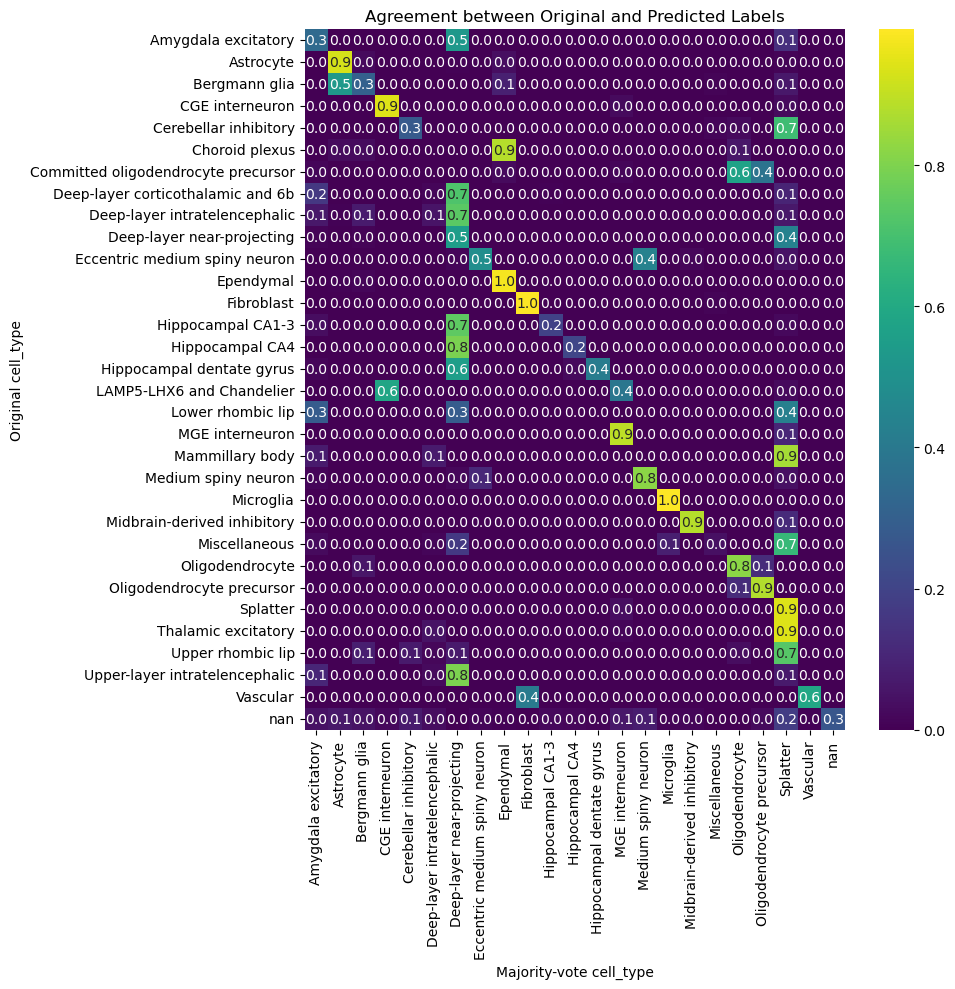

In [12]:
# Build confusion matrix
true_labels = adata.obs["cell_supertype"].astype(str)
pred_labels = adata.obs["predicted_annotation"].astype(str)

cm = pd.crosstab(true_labels, pred_labels, rownames=["Original"], colnames=["Majority-vote"])

# Normalize rows (fractions per original label, easier to read)
cm_norm = cm.div(cm.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm_norm, annot=True, fmt=".1f", cmap="viridis")
plt.title("Agreement between Original and Predicted Labels")
plt.ylabel("Original cell_type")
plt.xlabel("Majority-vote cell_type")
plt.tight_layout()
plt.show()

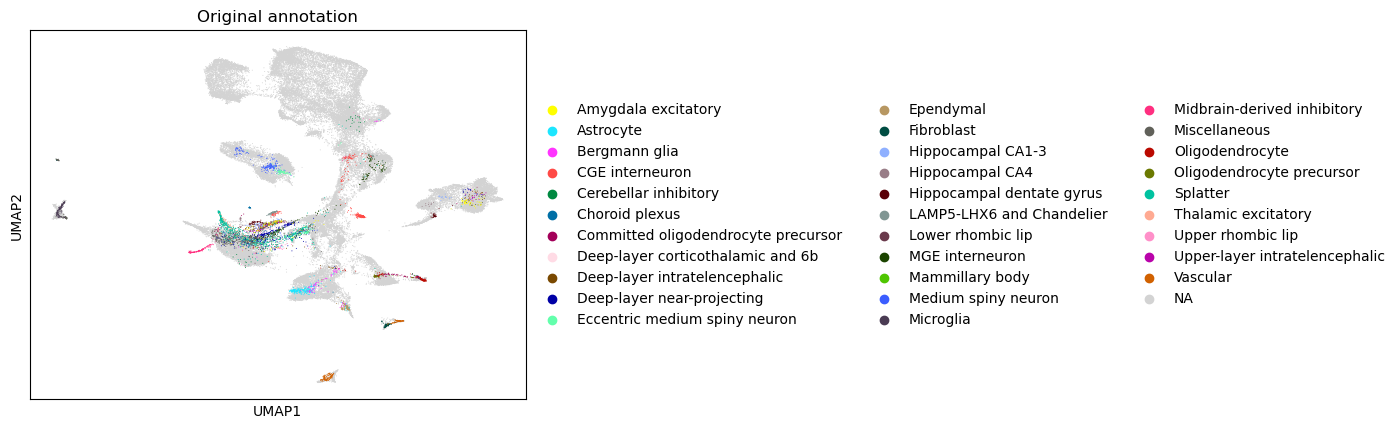

In [13]:
# Plot side by side
sc.pl.umap(
    adata,
    color="cell_supertype",
    title="Original annotation"
)

In [14]:
adata.obs.columns

Index(['species', 'tissue', 'sample_id', 'replicate', 'sample', 'region',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'Tissue', 'TotalUMIs',
       'organism_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id',
       'sex_ontology_term_id', 'development_stage_ontology_term_id',
       'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'cluster_id',
       'roi', 'cell_type', 'cell_supertype', 'Age', 'CellClass', 'Chemistry',
       'Region', 'Subregion', 'tissue_type', 'tissue_ontology_term_id',
       'cell_type_ontology_term_id', 'fraction_mitochondrial',
       'fraction_unsp

In [15]:
adata.obs['dataset_name'][adata.obs['Tissue'].notna()]

10X393_3:CCACACTGTTCACGAT    human
10X229_8:TTACGCCAGACTTGTC    human
10X173_4:TGAACGTCACCAAAGG    human
10X176_1:ACCATTTAGCACGATG    human
10X225_2:CATGCGGCACAGTGTT    human
                             ...  
10X248_6:GACCCTTTCATGCGGC    human
10X276_7:ACGGTTAAGCATCAAA    human
10X384_6:GAACACTAGCCGCTTG    human
10X277_1:AGTTCGACAACGATTC    human
10X216_3:GCATGATAGGTTCATC    human
Name: dataset_name, Length: 4496, dtype: category
Categories (3, object): ['nmr', 'human', 'human_dev']

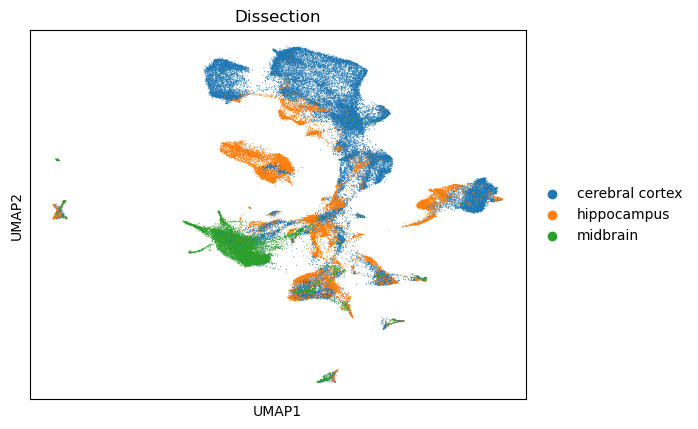

In [16]:
# Plot side by side
sc.pl.umap(
    adata,
    color="region",
    title="Dissection"
)

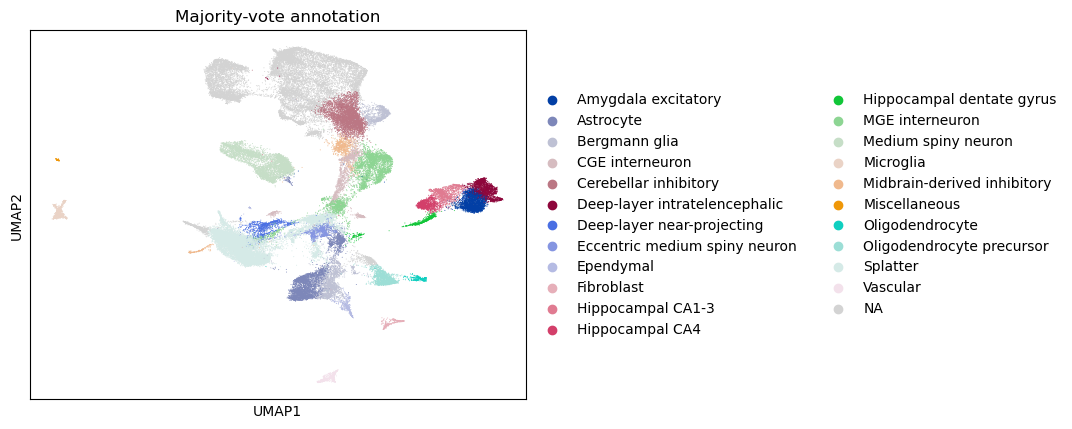

In [17]:
# Plot side by side
sc.pl.umap(
    adata,
    color="predicted_annotation",
    title="Majority-vote annotation"
)

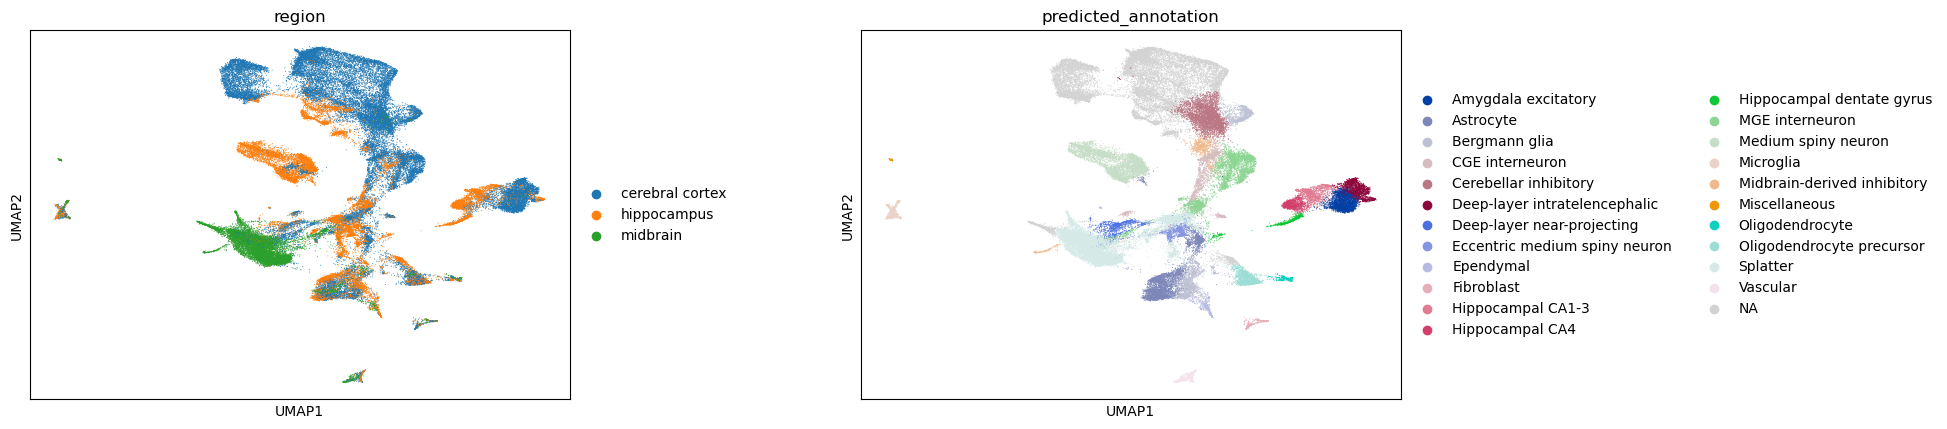

In [18]:
sc.pl.umap(adata, color=['region', 'predicted_annotation'], wspace=0.4, save=f"_predicted_ann_per_region_{rev_n}.png")

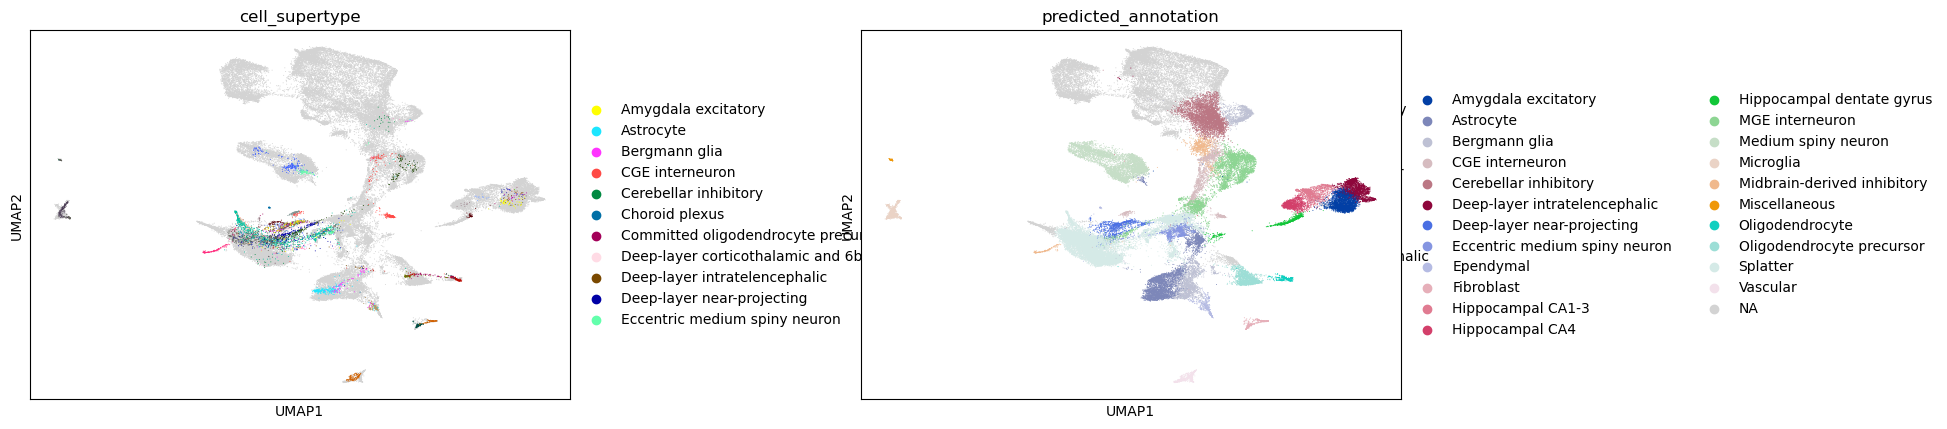

In [19]:
sc.pl.umap(adata, color=['cell_supertype', 'predicted_annotation'], wspace=0.4, save=f"_predicted_ann_{rev_n}.png")

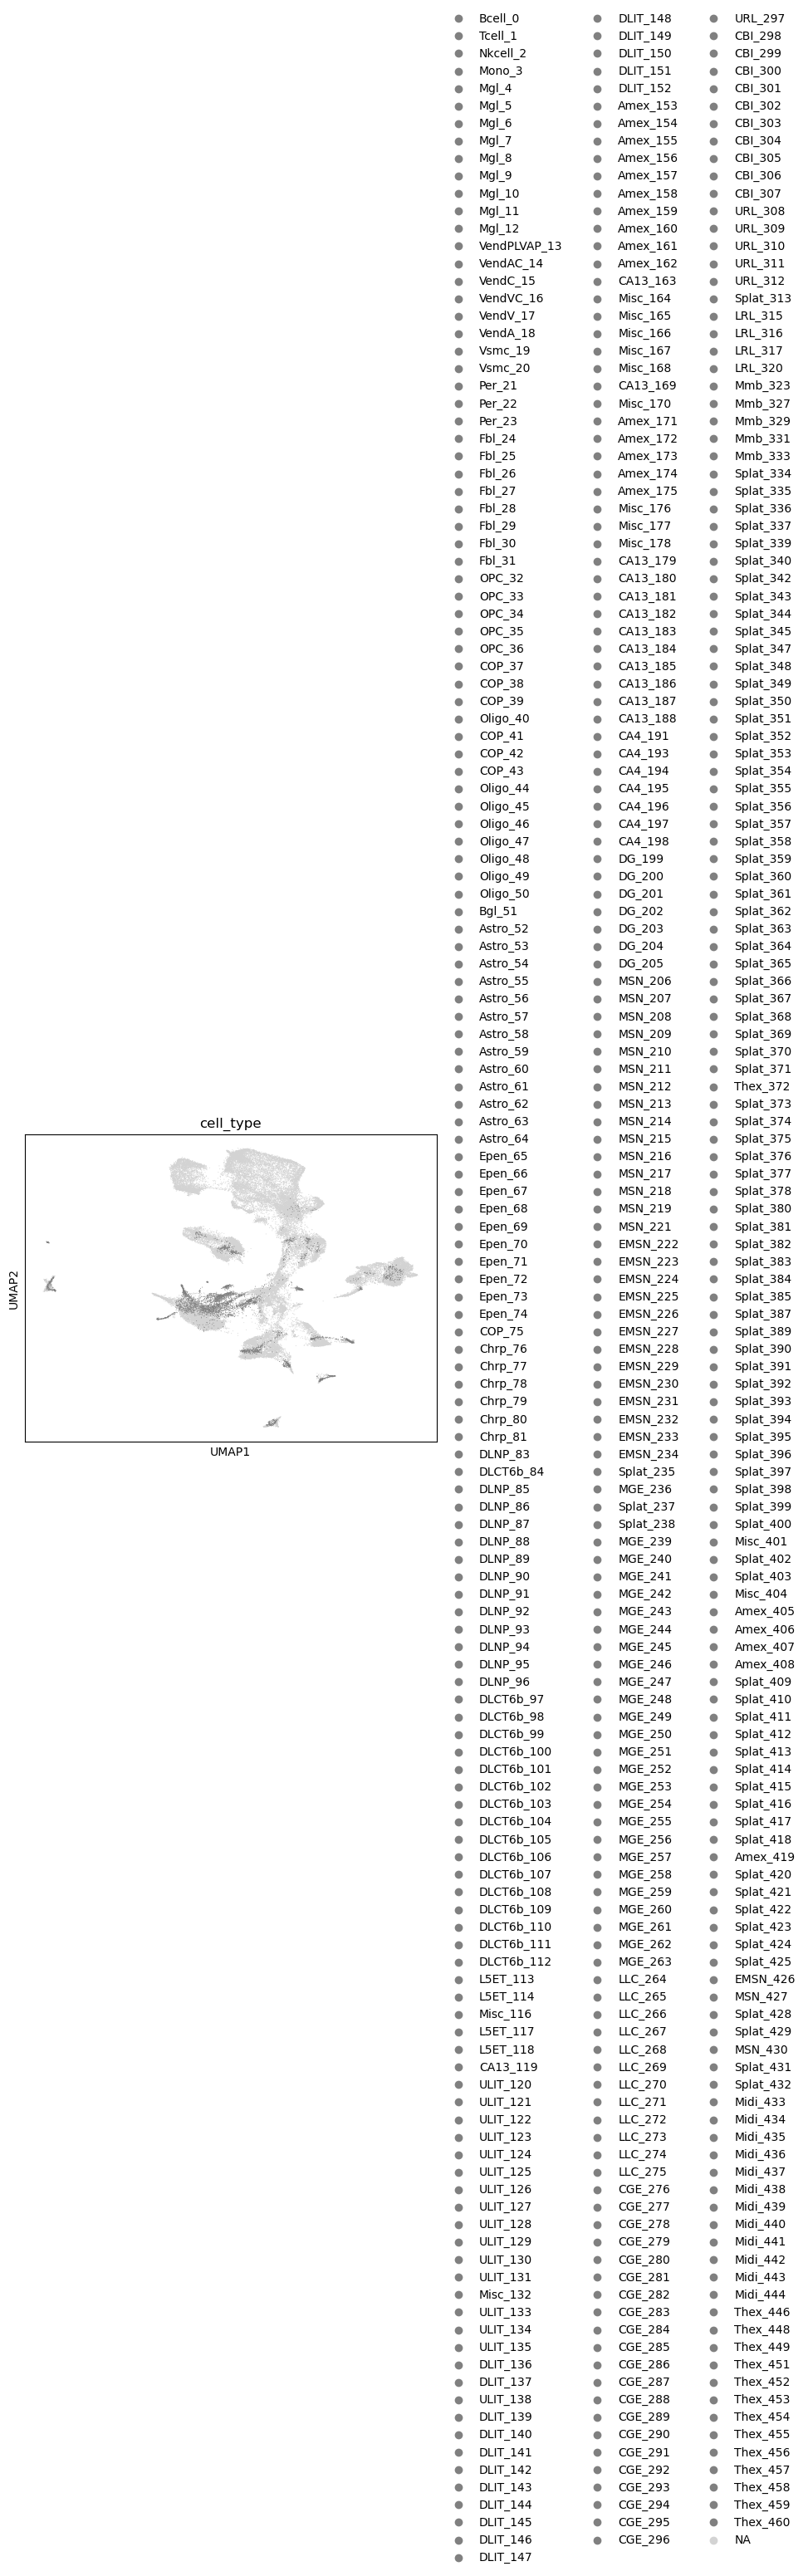

In [20]:
sc.pl.umap(adata, color=['cell_type'], wspace=0.4, save=f"_by celltype_{rev_n}.png")

In [29]:
nmr_data = adata[adata.obs['species'] == 'nmr'].copy()

In [22]:
cortex = nmr_data[nmr_data.obs['tissue'] == 'cerebral_cortex'].copy()
hippocampus = nmr_data[nmr_data.obs['tissue'] == 'hippocampus'].copy()
midbrain = nmr_data[nmr_data.obs['tissue'] == 'cerebral_cortex'].copy()

In [23]:
tissue_list = [cortex, hippocampus, midbrain]

<Axes: title={'center': 'Only NMR predicted annotation'}, xlabel='UMAP1', ylabel='UMAP2'>

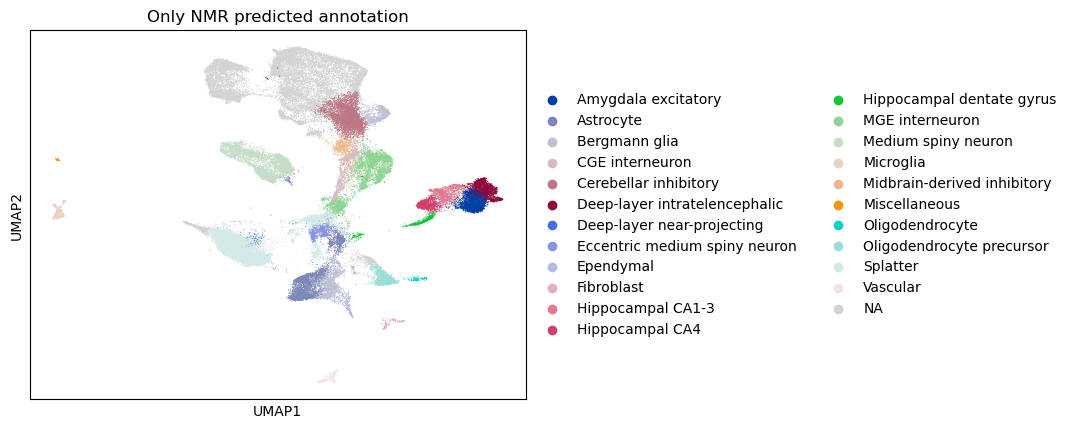

In [24]:
sc.pl.umap(
    nmr_data,
    color="predicted_annotation",
    show=False,
    title="Only NMR predicted annotation"
)

<Axes: title={'center': 'Only NMR by tissue'}, xlabel='UMAP1', ylabel='UMAP2'>

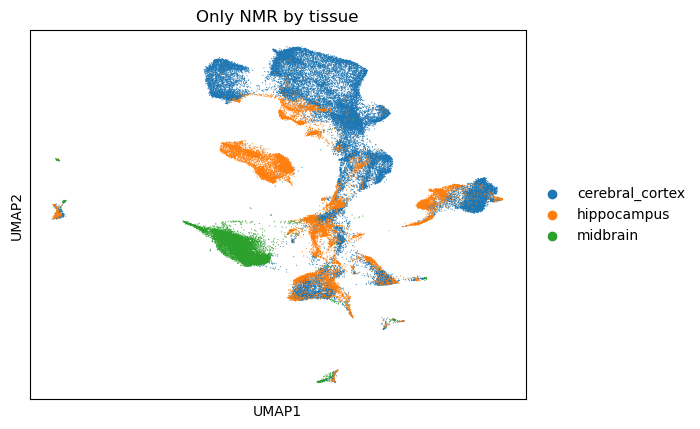

In [25]:
sc.pl.umap(
    adata[adata.obs['species'] == 'nmr'],
    color="tissue",
    show=False,
    title="Only NMR by tissue"
)


In [26]:
nmr_data.X

array([[-0.05698197, -0.04783586, -0.0278559 , ..., -0.05507769,
         0.47136933,  0.3605169 ],
       [-0.05462259, -0.04586391, -0.0267186 , ..., -0.05279925,
         0.34518446,  0.15480601],
       [-0.05186255, -0.04355614, -0.02538641, ..., -0.05013367,
        -0.07976772,  0.21492965],
       ...,
       [ 0.02778031,  0.02347795,  0.0138748 , ...,  0.02688929,
         0.12589901,  0.10508858],
       [ 0.02842353,  0.02402275,  0.01419834, ...,  0.02751216,
         0.12867327,  0.10742853],
       [ 0.02808751,  0.02373814,  0.01402931, ...,  0.02718677,
         0.12722472,  0.10620662]])

In [ ]:
np.isnan(nmr_data.X).any(axis=1).sum()


False

In [37]:
nmr_data

AnnData object with n_obs × n_vars = 57171 × 13337
    obs: 'species', 'tissue', 'sample_id', 'replicate', 'sample', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'Tissue', 'TotalUMIs', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'cluster_id', 'roi', 'cell_type', 'cell_supertype', 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'tissue_type', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'd

In [40]:
np.isnan(nmr_data.X).all(axis=0).sum()


0

In [42]:
import numpy as np
np.isnan(nmr_data.X).sum(axis=0)[:10]  # NaNs per gene


array([ 979,  760,  475,  201,   64, 1715, 2943,  169,   44, 1635])

In [43]:
# Replace all NaNs or infs in .X
nmr_data.X = np.nan_to_num(nmr_data.X, nan=0.0, posinf=0.0, neginf=0.0)


In [44]:
sc.pp.pca(nmr_data, svd_solver='arpack',n_comps=40)
sc.pp.neighbors(nmr_data, n_neighbors=40, n_pcs=40)
sc.tl.umap(nmr_data, min_dist=0.2)

/home/raquelcr/.conda/envs/scanpy-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


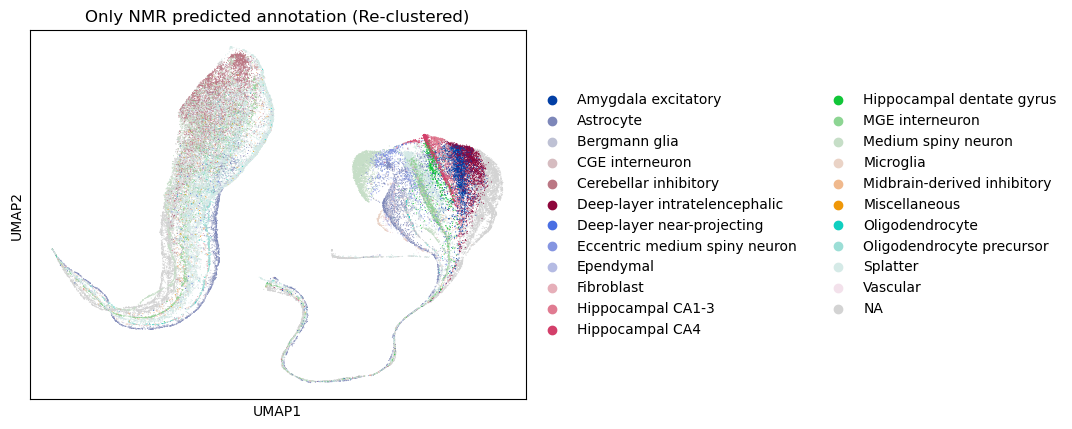

In [45]:
sc.pl.umap(
    nmr_data,
    color="predicted_annotation",
    title="Only NMR predicted annotation (Re-clustered)",
    save=f'_nmr_predicted{rev_n}.png')

In [48]:
nmr_data.obs['predicted_annotation'].value_counts()

predicted_annotation
Splatter                         10023
Medium spiny neuron               4470
Cerebellar inhibitory             4122
MGE interneuron                   3700
Astrocyte                         3548
Bergmann glia                     2789
Amygdala excitatory               2604
Deep-layer intratelencephalic     1826
Oligodendrocyte precursor         1339
Hippocampal CA1-3                 1196
CGE interneuron                   1195
Hippocampal CA4                   1050
Eccentric medium spiny neuron      856
Midbrain-derived inhibitory        808
Hippocampal dentate gyrus          578
Microglia                          543
Vascular                           433
Ependymal                          326
Fibroblast                         179
Oligodendrocyte                    132
Miscellaneous                      108
Deep-layer near-projecting          74
Name: count, dtype: int64

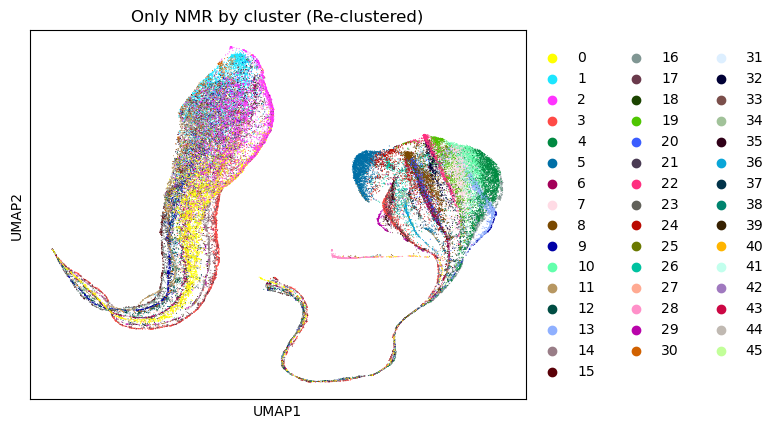

In [49]:
sc.pl.umap(
    nmr_data,
    color=leiden_res,
    title="Only NMR by cluster (Re-clustered)",
    save= f'_nmr_clusters{rev_n}.png'
)

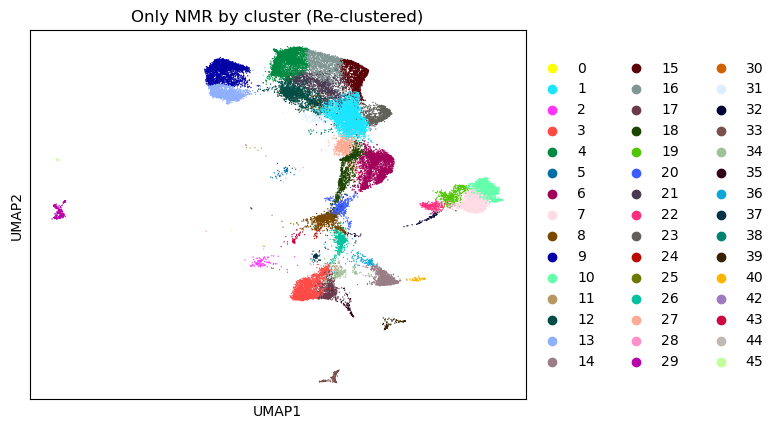

In [50]:
sc.pl.umap(
    cortex,
    color=leiden_res,
    title="Only NMR by cluster (Re-clustered)"
)

<Axes: title={'center': 'Only NMR by tissue (Re-clustered)'}, xlabel='UMAP1', ylabel='UMAP2'>

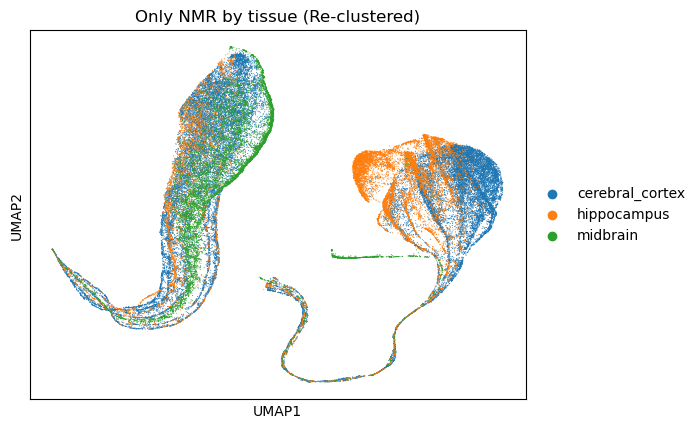

In [51]:
sc.pl.umap(
    nmr_data,
    color="tissue",
    show=False,
    title="Only NMR by tissue (Re-clustered)"
)

In [52]:
nmr_data.obs.columns

Index(['species', 'tissue', 'sample_id', 'replicate', 'sample', 'region',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'Tissue', 'TotalUMIs',
       'organism_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id',
       'sex_ontology_term_id', 'development_stage_ontology_term_id',
       'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'cluster_id',
       'roi', 'cell_type', 'cell_supertype', 'Age', 'CellClass', 'Chemistry',
       'Region', 'Subregion', 'tissue_type', 'tissue_ontology_term_id',
       'cell_type_ontology_term_id', 'fraction_mitochondrial',
       'fraction_unsp

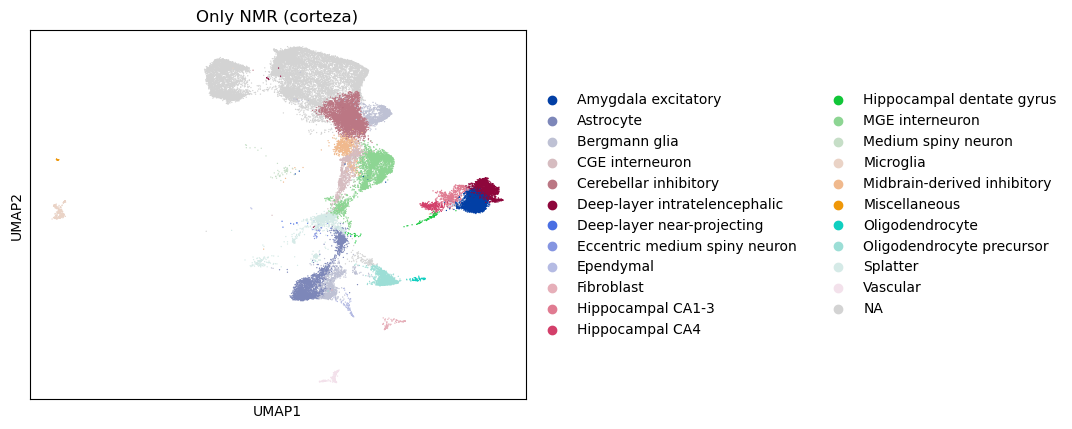

In [53]:
sc.pl.umap(
    cortex,
    color="predicted_annotation",
    title="Only NMR (corteza)"
)

In [54]:
cortex.obs['predicted_annotation'].value_counts()

predicted_annotation
Cerebellar inhibitory            4087
MGE interneuron                  2931
Amygdala excitatory              2555
Astrocyte                        2381
Bergmann glia                    1970
Deep-layer intratelencephalic    1670
Splatter                         1133
Oligodendrocyte precursor        1094
CGE interneuron                   979
Midbrain-derived inhibitory       732
Hippocampal CA1-3                 410
Hippocampal CA4                   289
Microglia                         286
Vascular                          188
Fibroblast                        110
Ependymal                          91
Hippocampal dentate gyrus          82
Oligodendrocyte                    62
Medium spiny neuron                55
Eccentric medium spiny neuron      30
Miscellaneous                      18
Deep-layer near-projecting          8
Name: count, dtype: int64

In [55]:
# Save object
filename= f'/home/raquelcr/scanpy/final_nmr_crossAnn{rev_n}.h5ad'
sc.write(filename, nmr_data)
print(f'Succesfully saved on {filename}')

Succesfully saved on /home/raquelcr/scanpy/final_nmr_crossAnn9.h5ad


In [56]:
!du -h $filename

5.3G	/home/raquelcr/scanpy/final_nmr_crossAnn9.h5ad


In [58]:
nmr_data

AnnData object with n_obs × n_vars = 57171 × 13337
    obs: 'species', 'tissue', 'sample_id', 'replicate', 'sample', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'Tissue', 'TotalUMIs', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'cluster_id', 'roi', 'cell_type', 'cell_supertype', 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'tissue_type', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'd

## Marker genes

In [59]:
sc.tl.rank_genes_groups(nmr_data, groupby="leiden_2.5", method="wilcoxon")

/home/raquelcr/.conda/envs/scanpy-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/raquelcr/.conda/envs/scanpy-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/raquelcr/.conda/envs/scanpy-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:440: P

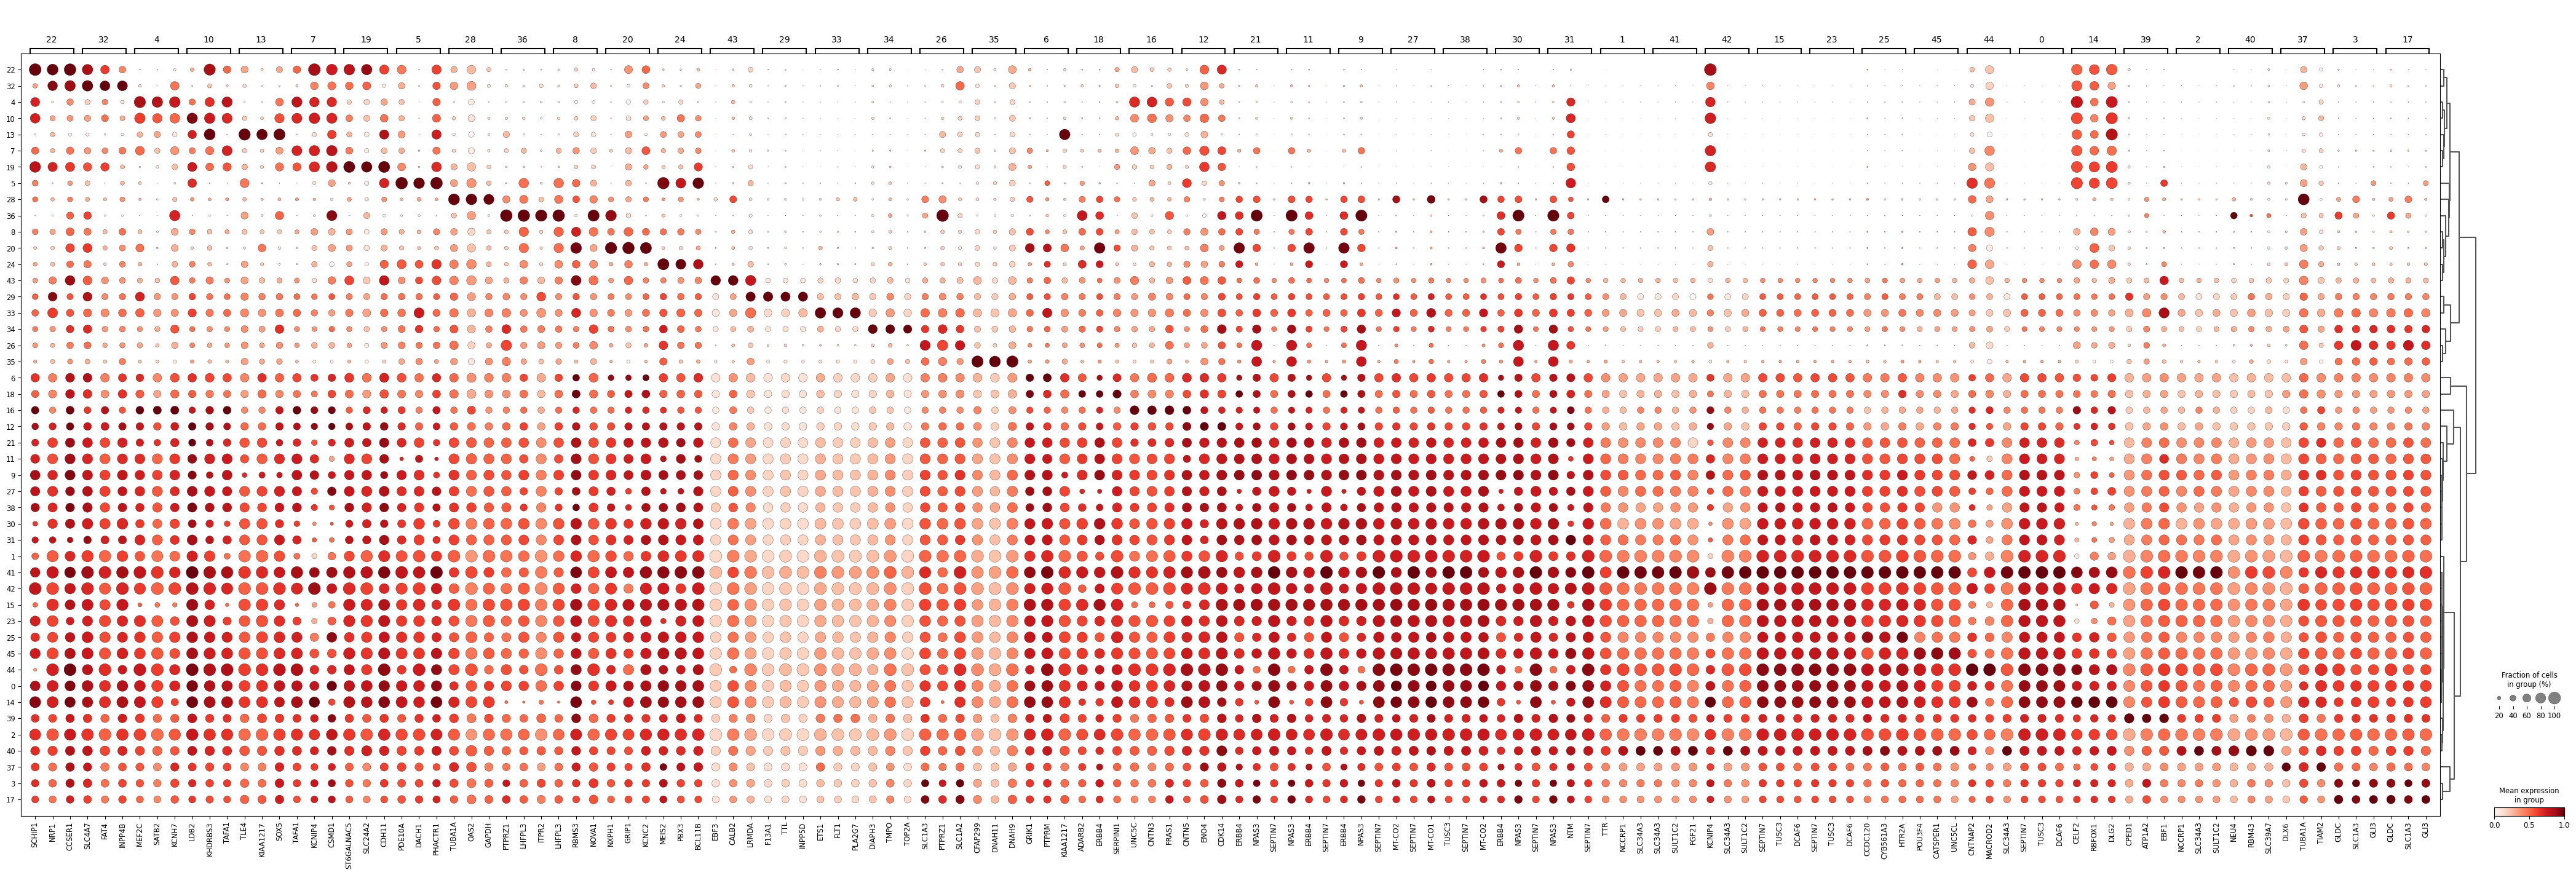

In [82]:
sc.pl.rank_genes_groups_dotplot(nmr_data, groupby="leiden_2.5", standard_scale="var", n_genes=3)

In [80]:
all_markers = pd.DataFrame(columns=['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj', 'cluster', 'predicted_annotation'])
for i in nmr_data.obs['leiden_2.5'].cat.categories:
    markers = sc.get.rank_genes_groups_df(nmr_data, group=str(i)).head(20)
    markers['cluster'] = i
    markers['predicted_annotation'] = nmr_data.obs['predicted_annotation'][nmr_data.obs['leiden_2.5'] == i][0]
    all_markers = pd.concat([all_markers, markers], ignore_index=True)

In [81]:
all_markers


names     scores  logfoldchanges         pvals     pvals_adj cluster  \
0     SEPTIN7  62.599613             NaN  0.000000e+00  0.000000e+00       0   
1       TUSC3  62.524048             NaN  0.000000e+00  0.000000e+00       0   
2       DCAF6  62.168804             NaN  0.000000e+00  0.000000e+00       0   
3       PCMT1  62.128586             NaN  0.000000e+00  0.000000e+00       0   
4       OSBP2  62.093204             NaN  0.000000e+00  0.000000e+00       0   
..        ...        ...             ...           ...           ...     ...   
915      AHRR   7.662150        5.821862  1.828456e-14  4.751505e-13      45   
916  SERPINB9   7.660963             NaN  1.845446e-14  4.751505e-13      45   
917    FBXO27   7.660181             NaN  1.856718e-14  4.751505e-13      45   
918     MASP2   7.659798             NaN  1.862252e-14  4.751505e-13      45   
919     GREM2   7.657814             NaN  1.891243e-14  4.751505e-13      45   

    predicted_annotation  
0               Splatter  
1               Splatter  
2               Splatter  
3               Splatter  
4               Splatter  
..                   ...  
915        Miscellaneous  
916        Miscellaneous  
917        Miscellaneous  
918        Miscellaneous  
919        Miscellaneous  

[920 rows x 7 columns]

In [98]:
all_markers

names     scores  logfoldchanges         pvals     pvals_adj cluster  \
0     SEPTIN7  62.599613             NaN  0.000000e+00  0.000000e+00       0   
1       TUSC3  62.524048             NaN  0.000000e+00  0.000000e+00       0   
2       DCAF6  62.168804             NaN  0.000000e+00  0.000000e+00       0   
3       PCMT1  62.128586             NaN  0.000000e+00  0.000000e+00       0   
4       OSBP2  62.093204             NaN  0.000000e+00  0.000000e+00       0   
..        ...        ...             ...           ...           ...     ...   
915      AHRR   7.662150        5.821862  1.828456e-14  4.751505e-13      45   
916  SERPINB9   7.660963             NaN  1.845446e-14  4.751505e-13      45   
917    FBXO27   7.660181             NaN  1.856718e-14  4.751505e-13      45   
918     MASP2   7.659798             NaN  1.862252e-14  4.751505e-13      45   
919     GREM2   7.657814             NaN  1.891243e-14  4.751505e-13      45   

    predicted_annotation  
0               Splatter  
1               Splatter  
2               Splatter  
3               Splatter  
4               Splatter  
..                   ...  
915        Miscellaneous  
916        Miscellaneous  
917        Miscellaneous  
918        Miscellaneous  
919        Miscellaneous  

[920 rows x 7 columns]

In [83]:
all_markers.to_csv(f'/home/raquelcr/scanpy/nmr_cluster_markers{rev_n}.csv', index=False)

In [ ]:
cluster_metrics.dropna(axis=1, how='all', inplace=True)
cluster_metrics.drop(columns=['global_majority_annotation', 'global_majority_frac'], inplace=True)
cluster_metrics['markers']= all_markers.groupby('cluster')['names'].apply(list)
cluster_metrics.drop(columns=['icc_species_fraction'], inplace=True)

In [96]:
cluster_metrics.to_csv(f'/home/raquelcr/scanpy/cluster_specs_{rev_n}.csv')

In [99]:
cluster_metrics

n_cells  pct_not_annotated  shannon_entropy_species  \
cluster                                                        
0           4700           0.831489                 0.654286   
1           4151           0.993014                 0.060074   
2           3743           0.978092                 0.152021   
3           2997           0.906907                 0.446711   
4           2942           1.000000                 0.000000   
5           2934           0.926040                 0.380532   
6           2876           0.956885                 0.256398   
7           2733           0.952799                 0.274385   
8           2206           0.803264                 0.715352   
9           2159           1.000000                 0.000000   
10          1852           0.985961                 0.106512   
11          1795           0.976602                 0.160118   
12          1661           1.000000                 0.000000   
13          1601           1.000000                 0.000000   
14          1450           0.923448                 0.389911   
15          1387           1.000000                 0.000000   
16          1379           1.000000                 0.000000   
17          1312           0.994665                 0.047960   
18          1264           0.934335                 0.349532   
19          1214           0.985173                 0.111315   
20          1195           0.793305                 0.735117   
21          1109           1.000000                 0.000000   
22          1062           0.988701                 0.089289   
23           999           0.992993                 0.060223   
24           964           0.887967                 0.506018   
25           857           0.086348                 0.424160   
26           831           0.998797                 0.013406   
27           810           0.990123                 0.079974   
28           766           1.000000                 0.000000   
29           717           0.757322                 0.799465   
30           712           1.000000                 0.000000   
31           671           1.000000                 0.000000   
32           613           0.942904                 0.315809   
33           544           0.795956                 0.729943   
34           542           0.907749                 0.443939   
35           505           0.645545                 0.937984   
36           481           1.000000                 0.000000   
37           431           0.962877                 0.228942   
38           404           1.000000                 0.000000   
39           360           0.497222                 0.999978   
40           312           0.423077                 0.982859   
41           297           0.111111                 0.503258   
42           278           0.050360                 0.287923   
43           262           0.893130                 0.490403   
44           147           0.040816                 0.246023   
45           132           0.818182                 0.684038   

             human_majority_annotation  human_majority_frac  \
cluster                                                       
0                             Splatter             0.410354   
1                Cerebellar inhibitory             0.724138   
2                             Splatter             0.280488   
3                            Astrocyte             0.813620   
4                                  NaN                  NaN   
5                  Medium spiny neuron             0.677419   
6                      MGE interneuron             0.669355   
7                  Amygdala excitatory             0.434109   
8                             Splatter             0.555300   
9                                  NaN                  NaN   
10       Deep-layer intratelencephalic             0.269231   
11                 Medium spiny neuron             0.976190   
12                                 NaN                

In [97]:
# dataframe from barcodes to clusters
nmr_data.obs[['sample','tissue', 'replicate', 'leiden_2.5', 'predicted_annotation' ]].to_csv(f'/home/raquelcr/scanpy/nmr_barcodes_to_clusters_{rev_n}.csv')

In [100]:
nmr_data.obs[['sample','tissue', 'replicate', 'leiden_2.5', 'predicted_annotation' ]]

sample           tissue  replicate leiden_2.5  \
GGGTGAATCTAGCCAA-1-NMR2   NMR2  cerebral_cortex        2.0          7   
AAAGGGCAGTTTGGCT-1-NMR2   NMR2  cerebral_cortex        2.0          7   
CAGAGCCGTAGATGTA-1-NMR2   NMR2  cerebral_cortex        2.0         33   
GCACATACACCTCTGT-1-NMR2   NMR2  cerebral_cortex        2.0         26   
ATCGGCGAGGGACACT-1-NMR2   NMR2  cerebral_cortex        2.0         26   
...                        ...              ...        ...        ...   
TACCGGGTCGTTCTCG-1-NMR6   NMR6         midbrain        2.0          2   
AGTACTGTCGCTTAAG-1-NMR6   NMR6         midbrain        2.0         42   
GGTGGCTCACAGTCGC-1-NMR6   NMR6         midbrain        2.0          2   
ATCTCTACAGTCGTTA-1-NMR6   NMR6         midbrain        2.0          2   
ACTATCTAGAGGCGTT-1-NMR6   NMR6         midbrain        2.0          2   

                        predicted_annotation  
GGGTGAATCTAGCCAA-1-NMR2  Amygdala excitatory  
AAAGGGCAGTTTGGCT-1-NMR2  Amygdala excitatory  
CAGAGCCGTAGATGTA-1-NMR2             Vascular  
GCACATACACCTCTGT-1-NMR2            Astrocyte  
ATCGGCGAGGGACACT-1-NMR2            Astrocyte  
...                                      ...  
TACCGGGTCGTTCTCG-1-NMR6             Splatter  
AGTACTGTCGCTTAAG-1-NMR6      CGE interneuron  
GGTGGCTCACAGTCGC-1-NMR6             Splatter  
ATCTCTACAGTCGTTA-1-NMR6             Splatter  
ACTATCTAGAGGCGTT-1-NMR6             Splatter  

[57171 rows x 5 columns]

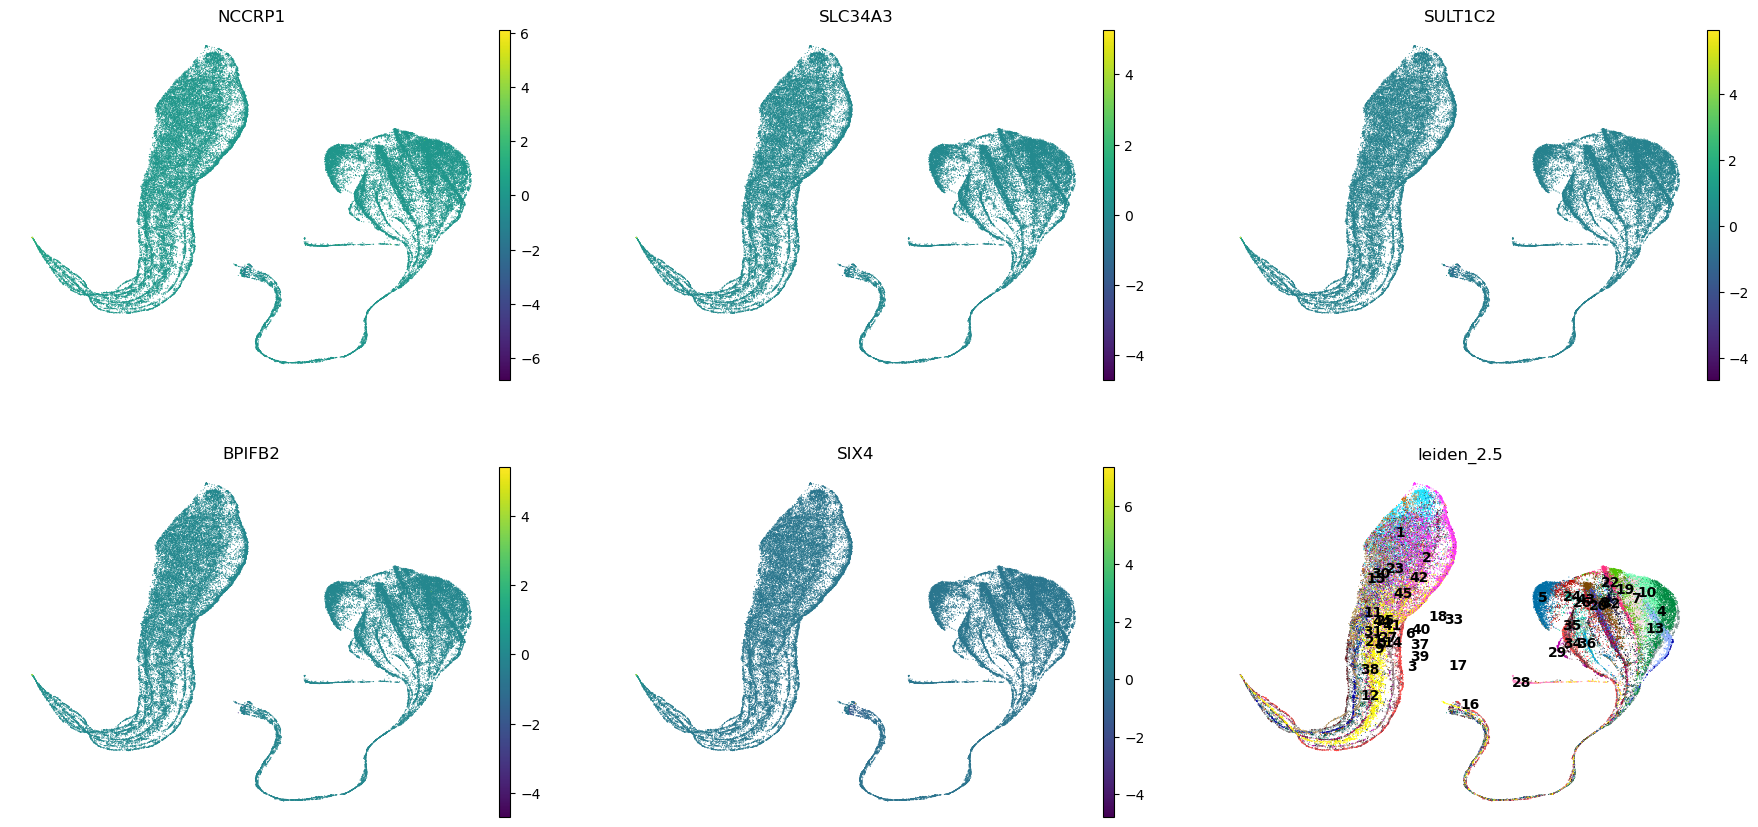

In [64]:
dc_cluster_genes = sc.get.rank_genes_groups_df(nmr_data, group="2").head(5)["names"]
sc.pl.umap(
    nmr_data,
    color=[*dc_cluster_genes, "leiden_2.5"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

In [62]:
nmr_data

AnnData object with n_obs × n_vars = 57171 × 13337
    obs: 'species', 'tissue', 'sample_id', 'replicate', 'sample', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'Tissue', 'TotalUMIs', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'cluster_id', 'roi', 'cell_type', 'cell_supertype', 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'tissue_type', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'd